In [4]:
import gym 
from custom_envs.windy_gridworld import WindyGridworldEnv
import numpy as np
from tqdm import tqdm
import time
from sklearn.tree import DecisionTreeRegressor
from function_approximators.replay import ReplayBuffer
import torch
from sklearn.utils.validation import check_is_fitted
from sklearn import tree
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor

# env = WindyGridworldEnv()
env = gym.make("CartPole-v1")

ModuleNotFoundError: No module named 'custom_envs'

In [2]:

def act(env, model, s, epsilon, explore):
    if explore and np.random.random_sample() < epsilon:
        action = env.action_space.sample()
    else:       
        try:
            Q = [model.predict(np.concatenate([s, actions[i]],-1).reshape(1,-1)) for i in range(env.action_space.n)]
            # print(Q)
            action = np.argmax(Q)
            # print(action)
        except:
            # print("init")
            action = env.action_space.sample()
    return action

def update(env, model, batch, gamma):
    inputs = np.concatenate([batch.states, [actions[int(i.item())] for i in batch.actions]], -1)
    preds = []
    try:
        for i in range(env.action_space.n):
            next_inputs = np.concatenate([batch.next_states, np.zeros((batch.actions.size()[0], 1)) + actions[i]], -1)
            preds.append(model.predict(next_inputs))
        preds = np.array(preds).T
        outputs = np.array(batch.rewards + gamma * (1-batch.done) * np.max(preds, 1).reshape(-1,1)).reshape(-1)
    except:
        # print("init")
        outputs = np.array(batch.rewards).reshape(-1)
        
    model.fit(inputs, outputs)
    
    # return q_loss


def play_episode(env, model, replay_buffer, batch_size, gamma, epsilon, explore, train, episode_length):
    s = env.reset()
    done = False
    episode_timesteps = 0
    episode_return = 0

    while not done:
        a = act(env, model, s, epsilon, explore=explore)
        s_next, r, done, _ = env.step(a)
        if train:
            replay_buffer.push(
                np.array(s, dtype=np.float32),
                np.array([a], dtype=np.float32),
                np.array(s_next, dtype=np.float32),
                np.array([r], dtype=np.float32),
                np.array([done], dtype=np.float32),
                )
            if len(replay_buffer) >= batch_size:
                batch = replay_buffer.sample(batch_size)
                update(env, model, batch, gamma)
        episode_timesteps += 1
        episode_return += r
        
        if episode_timesteps == episode_length:
            break
        s = s_next

    return episode_timesteps, episode_return


In [10]:
model = DecisionTreeRegressor(max_depth=5, min_samples_split=5, min_samples_leaf=5)
# model = RandomForestRegressor(n_estimators=5, max_depth=20)
# model = MLPRegressor()
replay_buffer = ReplayBuffer(1000)
# actions = [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]]
actions =  [[1,0],[0,1]]

In [11]:
max_timesteps = 20000
timesteps_elapsed = 0
episode_length = 200
eval_freq = 1000
eval_episodes = 5
gamma = 0.99
epsilon = 1
batch_size = 512

with tqdm(total=max_timesteps) as pbar:

    while timesteps_elapsed < max_timesteps:
        episode_timesteps, _ = play_episode(env, model, replay_buffer, batch_size=batch_size, gamma=gamma, epsilon=epsilon, 
                                            explore=True, train=True, episode_length=episode_length)
        timesteps_elapsed += episode_timesteps
        pbar.update(episode_timesteps)

        if timesteps_elapsed % eval_freq < episode_timesteps:
            eval_returns = 0
            for _ in range(eval_episodes):
                _ , episode_return = play_episode(env, model, replay_buffer, batch_size=batch_size, gamma=gamma, epsilon=epsilon, 
                                                explore=False, train=False, episode_length=episode_length)
                eval_returns += episode_return / eval_episodes

            epsilon = max(epsilon*0.7,0.03)
            # tree.plot_tree(model)
            pbar.write(f"Evaluation at timestep {timesteps_elapsed} returned a mean returns of {eval_returns}")
            pbar.write(f"Epsilon = {epsilon}")


  5%|▌         | 1003/20000 [00:03<01:22, 230.23it/s]Evaluation at timestep 1003 returned a mean returns of 9.4
Epsilon = 0.7
 10%|█         | 2035/20000 [00:08<01:16, 233.49it/s]Evaluation at timestep 2005 returned a mean returns of 10.8
Epsilon = 0.48999999999999994
 15%|█▌        | 3018/20000 [00:12<01:32, 184.28it/s]Evaluation at timestep 3004 returned a mean returns of 12.599999999999998
Epsilon = 0.3429999999999999
 20%|██        | 4023/20000 [00:17<01:07, 235.40it/s]Evaluation at timestep 4023 returned a mean returns of 12.600000000000001
Epsilon = 0.24009999999999992
 25%|██▌       | 5037/20000 [00:21<01:15, 197.80it/s]Evaluation at timestep 5009 returned a mean returns of 124.4
Epsilon = 0.16806999999999994
 30%|███       | 6032/20000 [00:26<00:56, 246.50it/s]Evaluation at timestep 6004 returned a mean returns of 10.0
Epsilon = 0.11764899999999995
 35%|███▌      | 7008/20000 [00:31<01:13, 177.95it/s]Evaluation at timestep 7000 returned a mean returns of 21.4
Epsilon = 0.082354

[Text(171.42403846153846, 199.32, 'X[2] <= 0.069\nmse = 165.754\nsamples = 512\nvalue = 20.011'),
 Text(101.40576923076924, 163.07999999999998, 'X[2] <= 0.012\nmse = 60.84\nsamples = 282\nvalue = 29.54'),
 Text(51.50769230769231, 126.83999999999999, 'X[1] <= -0.373\nmse = 31.842\nsamples = 113\nvalue = 36.552'),
 Text(25.753846153846155, 90.6, 'X[2] <= -0.006\nmse = 27.938\nsamples = 26\nvalue = 29.103'),
 Text(12.876923076923077, 54.359999999999985, 'X[2] <= -0.024\nmse = 15.443\nsamples = 13\nvalue = 33.119'),
 Text(6.438461538461539, 18.119999999999976, 'mse = 16.894\nsamples = 5\nvalue = 36.572'),
 Text(19.315384615384616, 18.119999999999976, 'mse = 2.426\nsamples = 8\nvalue = 30.961'),
 Text(38.63076923076923, 54.359999999999985, 'X[2] <= 0.005\nmse = 8.165\nsamples = 13\nvalue = 25.086'),
 Text(32.19230769230769, 18.119999999999976, 'mse = 0.98\nsamples = 8\nvalue = 26.43'),
 Text(45.06923076923077, 18.119999999999976, 'mse = 12.146\nsamples = 5\nvalue = 22.935'),
 Text(77.261538

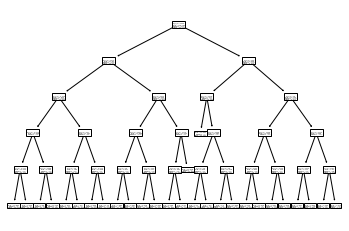

In [12]:
tree.plot_tree(model)

In [6]:
# model1 = DecisionTreeRegressor()

batch1 = replay_buffer.sample(32)
batch1.rewards[3] += 1

# inputs1 = np.concatenate([batch1.states, [actions[int(i.item())] for i in batch1.actions]], -1)
# outputs1 = batch1.rewards

inputs1 = np.concatenate([batch1.states, [actions[int(i.item())] for i in batch1.actions]], -1)
preds1 =[]
for i in range(env.action_space.n):
    next_inputs1 = np.concatenate([batch1.next_states, np.zeros((batch1.actions.size()[0], 1))+actions[i]], -1)
    preds1.append(model1.predict(next_inputs1))
preds1 = np.array(preds1).T
outputs1 = batch1.rewards + gamma * (1-batch1.done) * np.max(preds1, 1).reshape(-1,1)
print(outputs1)
tree.plot_tree(model1)

model1.fit(inputs1, outputs1)

ValueError: low >= high

In [22]:
batch = replay_buffer.sample(32)
np.concatenate([batch.next_states, np.zeros((batch.actions.size()[0], 1)) + actions[0]], -1).shape

preds = []
for i in range(env.action_space.n):
    next_inputs = np.concatenate([batch.next_states, np.zeros((batch.actions.size()[0], 1)) + actions[i]], -1)
    preds.append(model.predict(next_inputs))
preds = np.array(preds).T
outputs = np.array(batch.rewards + gamma * (1-batch.done) * np.max(preds, 1).reshape(-1,1)).reshape(-1)

In [23]:
outputs.shape

(32,)

In [28]:
np.array(batch.rewards).reshape(-1).shape

(32,)